# Machine Learning Applied to Humidity Control in Textile Processing

### An Implementation of Supervised Learning to Classify Low- vs. High-Humidity Days. 

<br>

In [0]:
# !pip install matplotlib
# !pip install seaborn --upgrade
# !pip install sklearn

In [0]:
# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [0]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import cm

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# cd into dataset dir
%cd /content/drive/My Drive/Colab Notebooks/_datasets/weather/
# !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/_datasets/weather


#### Read Data

In [6]:
filename = 'DS_sensor_weather.csv'
df_read = pd.read_csv(filename, index_col = 10)
print(df_read.shape)

(1095, 10)


#### Inspect Missing Values

In [7]:
df_read.isnull().sum(axis = 0)

air_pressure            3
air_temperature         5
avg_wind_direction      4
avg_wind_speed          3
max_wind_direction      3
max_wind_speed          4
rain_accumulation       6
rain_duration           3
relative_humidity       0
relative_humidity_pm    0
dtype: int64

In [0]:
# df.info()

#### Remove rows w/missing values

In [9]:
df = df_read.copy()
df.dropna(inplace=True)
print(df.shape)
df.isnull().sum(axis = 0)

(1064, 10)


air_pressure            0
air_temperature         0
avg_wind_direction      0
avg_wind_speed          0
max_wind_direction      0
max_wind_speed          0
rain_accumulation       0
rain_duration           0
relative_humidity       0
relative_humidity_pm    0
dtype: int64

In [0]:
# df.air_temperature.describe()

#### Feature Correlation

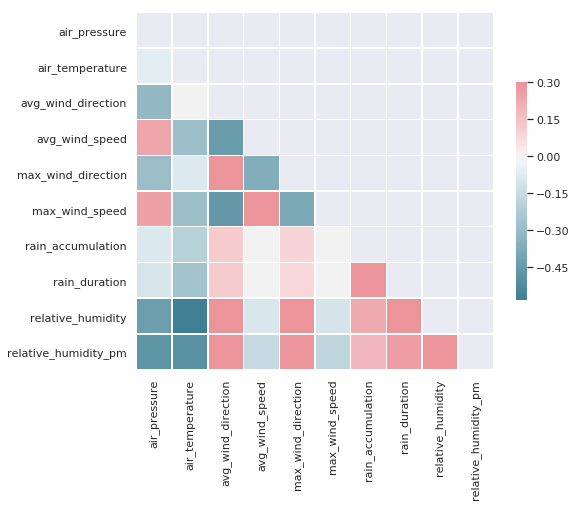

In [11]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Plot Scatter Matrix

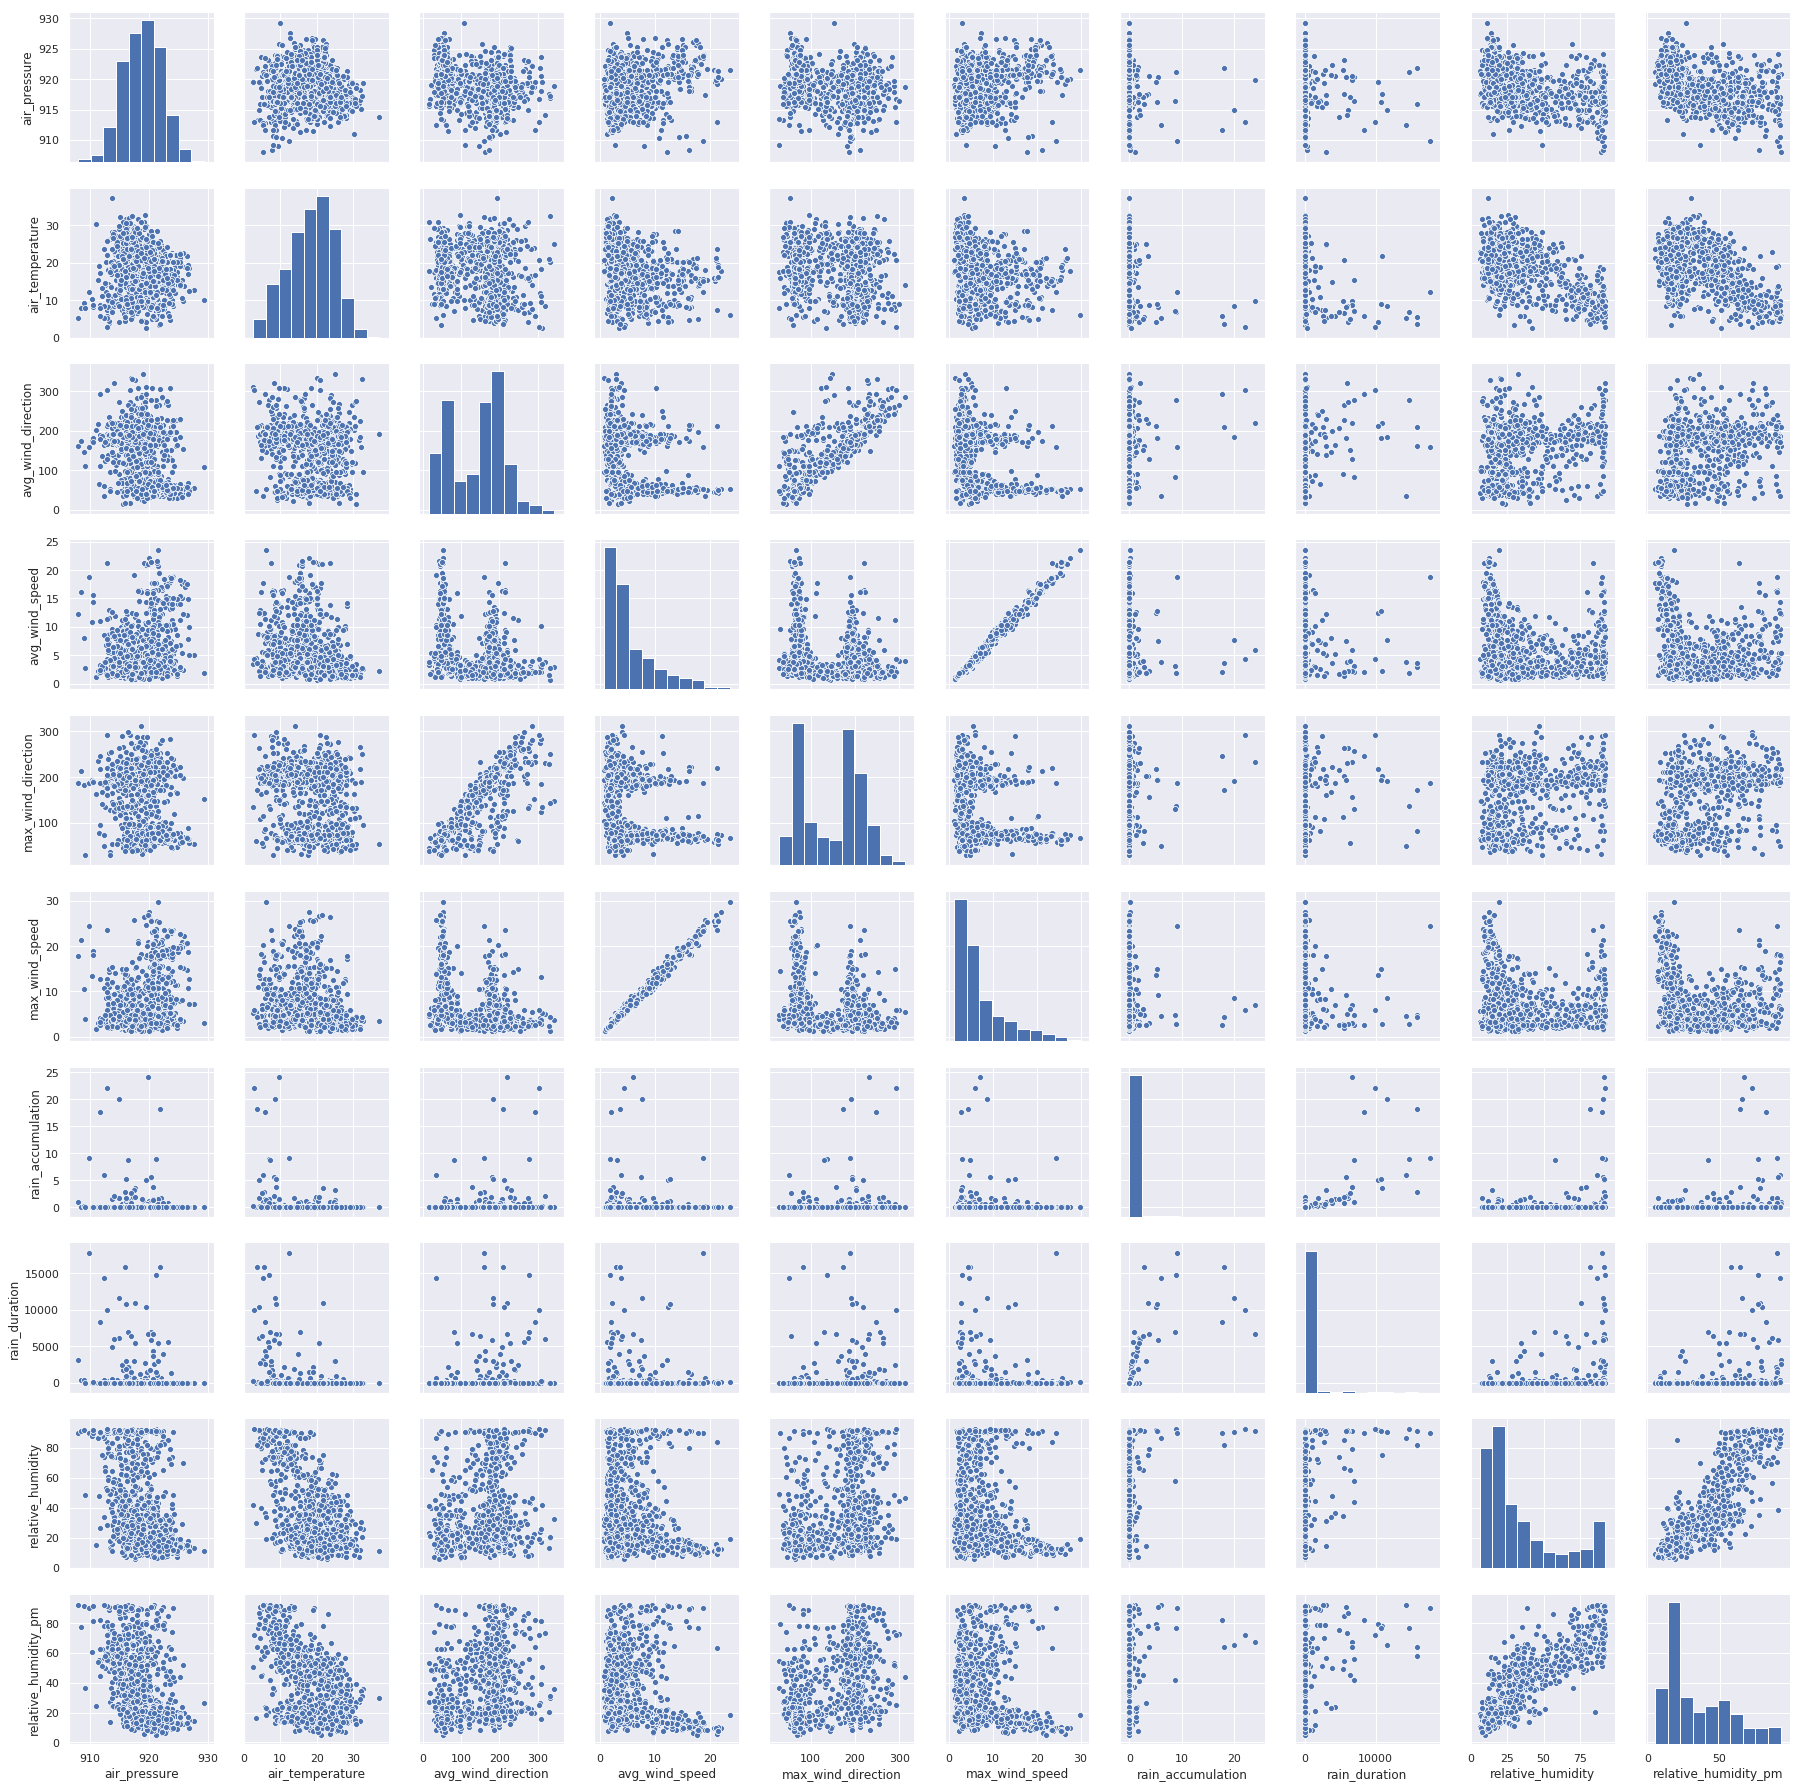

In [12]:
# sns.set(style="ticks")
plot = sns.pairplot(df)#, hue="species")

#### Simplify: Remove Max / Keep Avg

In [13]:
df.columns

Index(['air_pressure', 'air_temperature', 'avg_wind_direction',
       'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
       'rain_accumulation', 'rain_duration', 'relative_humidity',
       'relative_humidity_pm'],
      dtype='object')

In [14]:
df.drop(['max_wind_direction', 'max_wind_speed', ], axis=1, inplace=True)
df.columns

Index(['air_pressure', 'air_temperature', 'avg_wind_direction',
       'avg_wind_speed', 'rain_accumulation', 'rain_duration',
       'relative_humidity', 'relative_humidity_pm'],
      dtype='object')

#### Binarize and Encode Target

In [15]:
df['relative_humidity_pm_enc'] = df['relative_humidity_pm'].apply(lambda x: 0 if x <= 70 else 1)
df.head()

,air_pressure,air_temperature,avg_wind_direction,avg_wind_speed,rain_accumulation,rain_duration,relative_humidity,relative_humidity_pm,relative_humidity_pm_enc
row_number,,,,,,,,,
0,919.060000,23.790000,281.100000,3.080354,0.89,4.0,43.420000,37.160000,0
1,917.347688,21.891024,101.935179,2.443009,0.00,0.0,24.328697,20.426597,0
2,923.040000,15.910000,51.000000,17.067852,0.00,20.0,8.900000,14.460000,0
3,920.502751,21.188275,198.832133,4.337363,0.00,0.0,12.189102,12.742547,0
4,921.160000,6.830000,277.800000,1.856660,8.90,14730.0,92.410000,76.740000,1


#### Class Imbalance

In [16]:
tmp = df.copy().reset_index()
tmp.groupby('relative_humidity_pm_enc').agg({'row_number': ['count']})

,row_number
,count
relative_humidity_pm_enc,
0,965
1,99


### Modelling

#### Split Train/Test

In [0]:
X = df[['air_pressure', 'air_temperature', 'avg_wind_direction',
       'avg_wind_speed', 'rain_accumulation', 'rain_duration',
       'relative_humidity'
       ]]

y = df['relative_humidity_pm_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Normalize Features

In [0]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Fit Models

* Logistic Regression: produces a prediction model by estimating feature weights
* RandomForest Classifier:  operates by constructing a multitude of decision trees at training time; corrects for overfitting 

In [19]:
#######################
# Logistic Regression #
#######################
# fit data
lr_clf = (LogisticRegression(penalty='l2',  # regularization to reduce overfitting
                             C=1,           # controlling regularization (e.g. large values of C > less regularization)
                             random_state=123 # seed (make results reproducible)
                         )
       .fit(X_train_scaled, y_train))
print('model classes LR: Low={} High={}'.format(*lr_clf.classes_))

# print('model coeff (w): {}'.format(clf.coef_))
# print('number of model coeff (w): {}'.format(len(clf.coef_[0])))
# print('model intercept (b): {}'.format(clf.intercept_))

#################
# Random Forest #
#################
# create a parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 7],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [100]}
    
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_clf = RandomForestClassifier()
rf_grid_search = GridSearchCV(estimator = rf_clf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           n_jobs = -1)
# Fit the grid search to the data
rf_grid_search.fit(X_train_scaled, y_train)
rf_grid_search.best_params_

model classes LR: Low=0 High=1


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

#### Predict using trained model

In [0]:
#######################
# Logistic Regression #
#######################
# predict class for each test tuple
y_predict_lr = lr_clf.predict(X_test_scaled) # Returns the probability of the sample for each class in the model, where classes are ordered [0 1]
pd.Series(y_predict_lr, index = X_test.index.astype(int))[:10]

# predict class probability for each class 
y_predict_proba_lr = lr_clf.predict_proba(X_test_scaled) # Returns the probability of the sample for each class in the model, where classes are ordered [0 1]
y_predict_proba_lr[:10]

# predict class for class 1 'High' humidity_pm
y_predict_proba_high_lr = pd.Series(lr_clf.predict_proba(X_test_scaled)[:, 1], index = X_test.index.astype(int))
y_predict_proba_high_lr[:10]


#################
# Random Forest #
#################
# predict class for each test tuple
y_predict_rf = rf_grid_search.predict(X_test_scaled) 
# pd.Series(y_predict_rf, index = X_test.index.astype(int))[:10]

# predict class probability for each class 
y_predict_proba_rf = rf_grid_search.predict_proba(X_test_scaled) 
# y_predict_proba_rf[:10]

# predict class for class 1 'High' humidity_pm
y_predict_proba_high_rf = pd.Series(rf_grid_search.predict_proba(X_test_scaled)[:, 1], index = X_test.index.astype(int))
# y_predict_proba_high_rf[:10]

### Evaluation

#### Accuracy

In [21]:
# LR
print('Accuracy of LR classifier on training set: {:.3f}'
     .format(lr_clf.score(X_train_scaled, y_train)))
print('Accuracy of LR classifier on test set: {:.3f}'
     .format(lr_clf.score(X_test_scaled, y_test)))

# GB
print('\nAccuracy of RF classifier on training set: {:.3f}'
     .format(rf_grid_search.score(X_train_scaled, y_train)))
print('Accuracy of RF classifier on test set: {:.3f}\n'
     .format(rf_grid_search.score(X_test_scaled, y_test)))


Accuracy of LR classifier on training set: 0.944
Accuracy of LR classifier on test set: 0.936

Accuracy of RF classifier on training set: 0.981
Accuracy of RF classifier on test set: 0.940



#### Classification Report

In [22]:
target_names = ['Low', 'High']

# LR
average_precision = average_precision_score(y_test, y_predict_lr)
print('AP Logistic Regression Classifier: {0:0.2f}'.format(average_precision))
print(classification_report(y_test, y_predict_lr, target_names=target_names))

# RF
average_precision = average_precision_score(y_test, y_predict_rf)
print('AP Random Forest Classifier: {0:0.2f}'.format(average_precision))
print(classification_report(y_test, y_predict_rf, target_names=target_names))



AP Logistic Regression Classifier: 0.42
              precision    recall  f1-score   support

         Low       0.94      0.99      0.97       240
        High       0.80      0.46      0.59        26

   micro avg       0.94      0.94      0.94       266
   macro avg       0.87      0.72      0.78       266
weighted avg       0.93      0.94      0.93       266

AP Random Forest Classifier: 0.51
              precision    recall  f1-score   support

         Low       0.97      0.97      0.97       240
        High       0.69      0.69      0.69        26

   micro avg       0.94      0.94      0.94       266
   macro avg       0.83      0.83      0.83       266
weighted avg       0.94      0.94      0.94       266



#### Confusion Matrix

In [23]:
pd.DataFrame(confusion_matrix(y_test, y_predict_lr))

,0,1
0,237,3
1,14,12


In [24]:
pd.DataFrame(confusion_matrix(y_test, y_predict_rf))

,0,1
0,232,8
1,8,18


#### Area under the ROC Curve (AUC) 

AUC provides an aggregate measure of performance across all possible classification thresholds.

In [25]:
"""
the AUC is usually computed using the prediction score, 
and not the class label predictions. 
That means you should not be using predict() 
but rather predict_proba() 
[which produces two probabilities, make sure to grab the correct one] or decision_function().
"""

# LR
print('AUC score LR: {:.3f}'.format(roc_auc_score(y_test, y_predict_proba_high_lr)))

# RF
print('AUC score RF: {:.3f}'.format(roc_auc_score(y_test, y_predict_proba_high_rf)))




AUC score LR: 0.961
AUC score RF: 0.937


### Plotting
If there are many more negatives than positives (a characteristic of class imbalance problem), use PR. Otherwise, use ROC.

<br>
Precision Recall Curve

* The goal is to have a model be at the upper right corner, which is basically **getting only the true positives** with no false positives and no false negatives.

(0.0, 1.0)

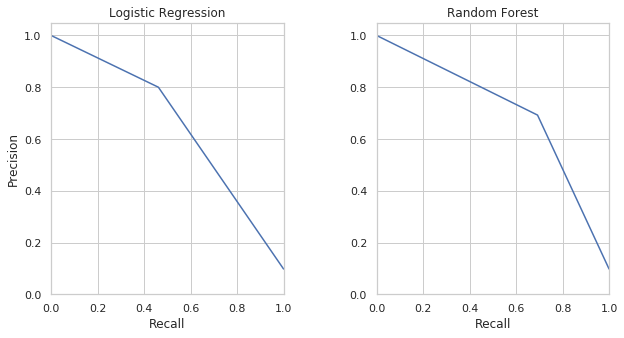

In [26]:
sns.set_style("whitegrid")
f, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(hspace = 0.6, wspace = 0.4)
axes = axes.flatten()

#######################
# Logistic Regression #
#######################
# get values for precision-recall plot
precision, recall, _ = precision_recall_curve(y_test, y_predict_lr)

# plot precision/recall
plot = sns.lineplot(x=recall, y=precision, data=None, ax=axes[0])
axes[0].set(xlabel='Recall', ylabel='Precision')
axes[0].set_title('Logistic Regression')
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlim([0.0, 1.0])

# get values for precision-recall plot
precision, recall, _ = precision_recall_curve(y_test, y_predict_rf)

# plot precision/recall
plot = sns.lineplot(x=recall, y=precision, data=None, ax=axes[1])
axes[1].set(xlabel='Recall')
axes[1].set_title('Random Forest')
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])

<br>

Receiver Operating Characteristic Curve (ROC curve)

* The goal is to have a model be at the upper left corner, which is basically **getting no false positives**.

(0.0, 1.0)

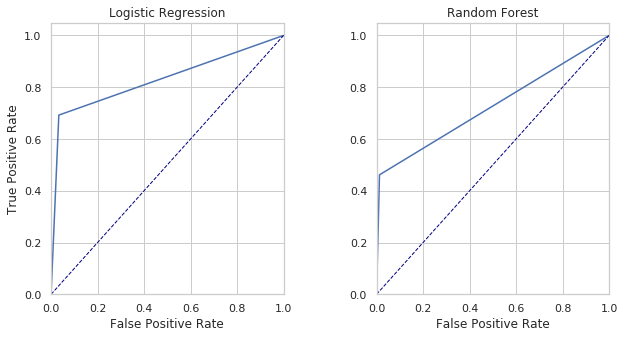

In [27]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(hspace = 0.6, wspace = 0.4)
axes = axes.flatten()
#################
# Random Forest #
#################

# get values for ROC plot
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# plot ROC
plot = sns.lineplot(x=fpr_lr, y=tpr_lr, data=None, ax=axes[0])
axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[0].set_title('Logistic Regression')
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlim([0.0, 1.0])


# get values for ROC plot
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# plot ROC
plot = sns.lineplot(x=fpr_lr, y=tpr_lr, data=None, ax=axes[1])
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set(xlabel='False Positive Rate')
axes[1].set_title('Random Forest')
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])

### TODO

* implement CV
* [randomized parameter search before grid search for RF](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
* use hold out set